# Segmentare Lesioni Cutanee con U-Net e PyTorch

Scopriamo in questo notebook come segmentare delle lesioni cutanee con un dataset leggero e un semplice U-Net!

### Carichiamo le librerie necessarie

In [1]:
import os  # Libreria per operazioni di sistema (gestione dei percorsi di file)
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split  
import torch  # La nostra libreria preferita :)
import torch.nn as nn  # Modulo di PyTorch per la definizione di reti neurali
import torch.optim as optim  # Modulo di PyTorch per gli ottimizzatori
from torch.utils.data import DataLoader, Dataset  # Moduli per la gestione dei dataset e dei data loader. 
                                                  # Andate a recuperare il video dedicato!
from torchvision import transforms  # Modulo di PyTorch per le trasformazioni delle immagini
from PIL import Image  # Libreria per la gestione delle immagini

### Importiamo il Dataset ISIC

Il dataset ISIC (International Skin Imaging Collaboration) è una raccolta di immagini dermoscopiche. Contiene immagini di lesioni cutanee annotate da esperti e viene ampiamente utilizzato per addestrare algoritmi di segmentazione.

In [2]:
# Definizione dei percorsi alle directory del dataset ISIC
# Sul vostro PC, cambiate il percorso a seconda di dove avete posizionato i file!
TRAIN_DATA_PATH = "ISIC dataset/ISBI2016_ISIC_Part1_Training_Data"  # Percorso delle immagini di training
TRAIN_GT_PATH = "ISIC dataset/ISBI2016_ISIC_Part1_Training_GroundTruth"  # Percorso delle maschere di training
TEST_DATA_PATH = "ISIC dataset/ISBI2016_ISIC_Part1_Test_Data"  # Percorso delle immagini di test
TEST_GT_PATH = "ISIC dataset/ISBI2016_ISIC_Part1_Test_GroundTruth"  # Percorso delle maschere di test

In [3]:
# Ottieniamo la lista di tutti i file di immagini e maschere
image_files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith(('.jpg','png'))]
mask_files = [f for f in os.listdir(TRAIN_GT_PATH) if f.endswith(('.jpg','png'))]

# Ci sono 900 immagini e maschere nel datasets
print(f"Numero di immagini trovate: {len(image_files)}")
print(f"Numero di maschere trovate: {len(mask_files)}")

Numero di immagini trovate: 900
Numero di maschere trovate: 900


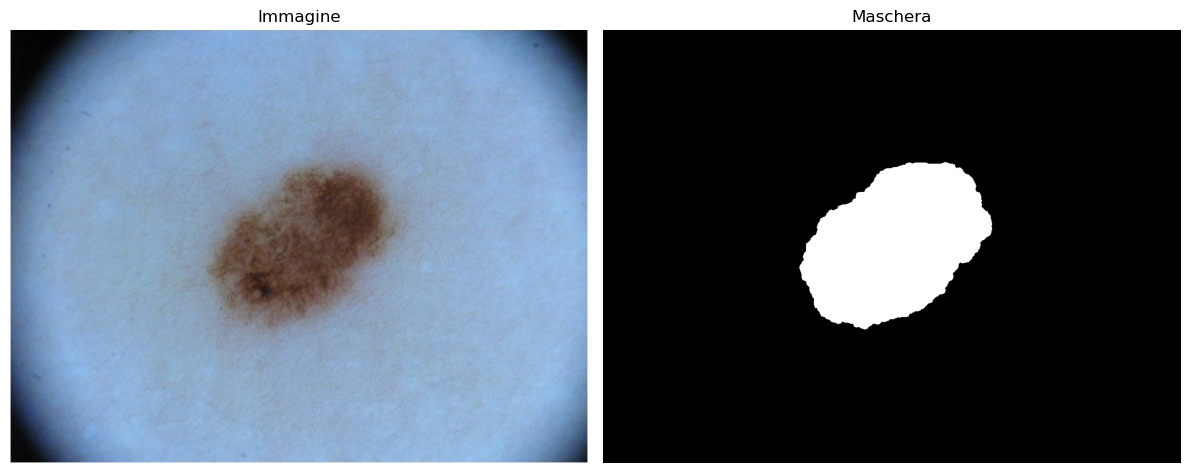

In [7]:
# Selezioniamo la prima delle immagini e delle maschere per l'analisi
sample_image_path = os.path.join(TRAIN_DATA_PATH, image_files[5])
sample_mask_path = os.path.join(TRAIN_GT_PATH, mask_files[5])

# Carichiamo la prima immagine e la prima maschera
image = Image.open(sample_image_path)  # l'immagine a colori
mask = Image.open(sample_mask_path)  # la maschera

# Creiamo una figura con due sottotrame 
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 riga, 2 colonne
axes[0].imshow(image)
axes[0].set_title('Immagine')
axes[0].axis('off')  # Nascondiamo gli assi
axes[1].imshow(mask, cmap='gray')  # cmap='gray' per mostrare la maschera in scala di grigi
axes[1].set_title('Maschera')
axes[1].axis('off')  # Nascondiamo gli assi
plt.tight_layout()
plt.show()

In [10]:
# 1. Le maschere sono in scala di grigi? (devono avere un solo canale)
if mask.mode == 'L':  # 'L' indica un'immagine in scala di grigi
    print("La maschera è in scala di grigi.")
else:
    print(f"La maschera NON è in scala di grigi. La modalità della maschera è {mask.mode}.")

# La risposta è sì!

La maschera è in scala di grigi.


In [11]:
# 2. Le maschere sono binarizzate? (valori solo 0 e 255)
unique_values_mask = set(mask.getdata())  # Trova i valori unici nella maschera
print(f"Valori unici presenti nella maschera: {unique_values_mask}")

# La risposta è sì!

Valori unici presenti nella maschera: {0, 255}


In [14]:
# 3. Le immagini sono RGB? (devono avere 3 canali)
if image.mode == 'RGB':  # 'RGB' indica un'immagine a colori
    print("L'immagine è in formato RGB.")
else:
    print(f"L'immagine NON è in formato RGB. La modalità dell'immagine è {image.mode}.")

# La risposta è sì!

L'immagine è in formato RGB.


In [15]:
# 4. Quali sono le dimensioni delle immagini e delle maschere?
image_width, image_height = image.size  # Ottieni larghezza e altezza dell'immagine
mask_width, mask_height = mask.size  # Ottieni larghezza e altezza della maschera

print(f"Dimensioni dell'immagine: {image_width}x{image_height}") #1022x767
print(f"Dimensioni della maschera: {mask_width}x{mask_height}") #1022x767

Dimensioni dell'immagine: 1022x767
Dimensioni della maschera: 1022x767


Siamo sicuri che le dimensioni siano le stesse per tutte le immagini?

In [18]:
# Ottieni le dimensioni di tutte le immagini
image_dimensions = set()  # Insieme per mantenere solo dimensioni uniche
min_width = float('inf')  # Inizializza con un valore molto grande
min_height = float('inf')  # Inizializza con un valore molto grande

for image_file in image_files:
    image_path = os.path.join(TRAIN_DATA_PATH, image_file)
    image = Image.open(image_path)
    width, height = image.size
    image_dimensions.add((width, height))  # Aggiungi la dimensione (larghezza, altezza) all'insieme
    
    # Aggiorna la minima larghezza e altezza
    min_width = min(min_width, width)
    min_height = min(min_height, height)

print(f"Dimensioni uniche delle immagini: {image_dimensions}")
print(f"Numero di dimensioni uniche delle immagini: {len(image_dimensions)}")

Dimensioni uniche delle immagini: {(965, 724), (4288, 2848), (1502, 1026), (964, 640), (957, 640), (963, 629), (2725, 2082), (722, 542), (960, 645), (838, 614), (3024, 2016), (722, 545), (724, 542), (2583, 2096), (1064, 702), (959, 634), (853, 680), (2601, 1909), (1936, 1296), (1502, 1016), (2313, 1985), (2117, 1988), (1062, 701), (949, 626), (576, 768), (1022, 767), (2101, 1943), (919, 802), (1502, 1043), (1504, 1129), (2012, 1956), (833, 680), (3008, 2000), (1079, 705), (767, 576), (962, 641), (1936, 1936), (796, 682), (2597, 2185), (944, 1127), (1456, 1018), (771, 750), (965, 649), (958, 642), (2283, 1824), (679, 566), (962, 671), (1024, 768), (962, 674), (966, 638), (824, 719), (1008, 711), (2565, 2000), (2048, 1536), (965, 624), (722, 543), (1057, 704), (1028, 753), (964, 720), (1502, 1051), (2592, 1944), (1057, 707), (1045, 705), (3072, 2304), (1019, 717), (957, 723), (3872, 2592), (1503, 1129), (959, 638), (718, 542), (2314, 2067), (962, 722), (2816, 2112), (2272, 1704)}
Numero 

Dovremo fare resize delle immagini prima che entrino nel U-Net!

In [19]:
print(f"Minima dimensione orizzontale: {min_width}")
print(f"Minima dimensione verticale: {min_height}")

Minima dimensione orizzontale: 576
Minima dimensione verticale: 542


Scegliamo di fare resize (128x128)! Voi potete provare con un valore diverso se preferite e cambiare il codice più sotto di conseguenza!

In [20]:
# Riepilogo di tutte le caratteristiche 
print("\n--- Riepilogo delle caratteristiche ---")
print(f"Valori unici nella maschera: {unique_values_mask}")
print(f"La maschera è in scala di grigi: {'Sì' if mask.mode == 'L' else 'No'}")
print(f"L'immagine è RGB: {'Sì' if image.mode == 'RGB' else 'No'}")
print(f"Dimensioni dell'immagine: {image_width}x{image_height}")
print(f"Dimensioni della maschera: {mask_width}x{mask_height}")
print(f"Numero di dimensioni uniche delle immagini: {len(image_dimensions)}")


--- Riepilogo delle caratteristiche ---
Valori unici nella maschera: {0, 255}
La maschera è in scala di grigi: Sì
L'immagine è RGB: Sì
Dimensioni dell'immagine: 1022x767
Dimensioni della maschera: 1022x767
Numero di dimensioni uniche delle immagini: 74


### Classe personalizzata per il Dataset ISIC

In [4]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path  # Percorso alle immagini
        self.masks_path = masks_path  # Percorso alle maschere
        self.image_files = sorted(os.listdir(images_path))  # Lista dei file immagine ordinati alfabeticamente
        self.mask_files = sorted(os.listdir(masks_path))  # Lista dei file maschera ordinati alfabeticamente
        self.transform = transform  # Trasformazioni applicate alle immagini e maschere. Dobbiamo fare resize
                                    # e trasformarle in tensori torch!
    
    def __len__(self):
        return len(self.image_files)  # Restituisce il numero totale di immagini nel dataset
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.image_files[idx])  # Percorso completo dell'immagine corrente
        mask_path = os.path.join(self.masks_path, self.mask_files[idx])  # Percorso completo della maschera corrente
        
        image = Image.open(img_path)  # Apre l'immagine 
        mask = Image.open(mask_path)  # Apre la maschera 
        
        if self.transform:
            image = self.transform(image)  # Applica le trasformazioni all'immagine
            mask = self.transform(mask)  # Applica le trasformazioni alla maschera
        
        return image, mask  # Restituisce immagine e maschera come tensori

### Modello U-Net

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Primo strato convoluzionale
                nn.ReLU(inplace=True),  # Funzione di attivazione ReLU
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Secondo strato convoluzionale
                nn.ReLU(inplace=True)  # Funzione di attivazione ReLU
            )

        # Definizione dei blocchi di codifica (encoder)
        self.enc1 = conv_block(3, 64)  # Blocco di codifica 1
        self.enc2 = conv_block(64, 128)  # Blocco di codifica 2
        self.enc3 = conv_block(128, 256)  # Blocco di codifica 3
        self.enc4 = conv_block(256, 512)  # Blocco di codifica 4

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Livello di pooling per ridurre la dimensione

        self.bottleneck = conv_block(512, 1024)  # Collo di bottiglia (bottleneck) della rete

        # Definizione dei blocchi di decodifica (decoder)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # Strato di upsampling
        self.dec4 = conv_block(1024, 512)  # Blocco di decodifica 4

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Strato di upsampling
        self.dec3 = conv_block(512, 256)  # Blocco di decodifica 3

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # Strato di upsampling
        self.dec2 = conv_block(256, 128)  # Blocco di decodifica 2

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # Strato di upsampling
        self.dec1 = conv_block(128, 64)  # Blocco di decodifica 1

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)  # Strato convoluzionale finale con 1 canale di output

    def forward(self, x):
        # Codifica
        enc1 = self.enc1(x)  # Input: (batch_size, 3, 128, 128) -> Output: (batch_size, 64, 128, 128)
        enc2 = self.enc2(self.pool(enc1))  # Input: (batch_size, 64, 128, 128) -> Output: (batch_size, 128, 64, 64)
        enc3 = self.enc3(self.pool(enc2))  # Input: (batch_size, 128, 64, 64) -> Output: (batch_size, 256, 32, 32)
        enc4 = self.enc4(self.pool(enc3))  # Input: (batch_size, 256, 32, 32) -> Output: (batch_size, 512, 16, 16)

        # Collo di bottiglia
        bottleneck = self.bottleneck(self.pool(enc4))  # Input: (batch_size, 512, 16, 16) -> Output: (batch_size, 1024, 8, 8)

        # Decodifica
        dec4 = self.dec4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))  # Input: (batch_size, 1024, 8, 8) -> Output: (batch_size, 512, 16, 16)
        dec3 = self.dec3(torch.cat((self.upconv3(dec4), enc3), dim=1))  # Input: (batch_size, 512, 16, 16) -> Output: (batch_size, 256, 32, 32)
        dec2 = self.dec2(torch.cat((self.upconv2(dec3), enc2), dim=1))  # Input: (batch_size, 256, 32, 32) -> Output: (batch_size, 128, 64, 64)
        dec1 = self.dec1(torch.cat((self.upconv1(dec2), enc1), dim=1))  # Input: (batch_size, 128, 64, 64) -> Output: (batch_size, 64, 128, 128)

        return torch.sigmoid(self.final_conv(dec1))  # Applica la funzione di attivazione sigmoid
        # Output: (batch_size, 1, 128, 128)


### Carichiamo i Dataset e definiamo gli iper-parametri

In [6]:
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
train_dataset = ISICDataset(TRAIN_DATA_PATH, TRAIN_GT_PATH, transform)
test_dataset = ISICDataset(TEST_DATA_PATH, TEST_GT_PATH, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = UNet()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Funzione di perdita: Binary Cross-Entropy Loss

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

In [9]:
criterion = nn.BCELoss()

### Ciclo di Addestramento

In [24]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images, masks
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, masks)
        loss.backward() 
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [26]:
# Qui runniamo l'addestramento
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}")

# Salviamo i parametri del modello
torch.save(model.state_dict(), "unet_isic.pth")

Epoch 1/20, Train Loss: 0.5140
Epoch 2/20, Train Loss: 0.3327
Epoch 3/20, Train Loss: 0.2563
Epoch 4/20, Train Loss: 0.2325
Epoch 5/20, Train Loss: 0.2103
Epoch 6/20, Train Loss: 0.1822
Epoch 7/20, Train Loss: 0.1682
Epoch 8/20, Train Loss: 0.1662
Epoch 9/20, Train Loss: 0.1515
Epoch 10/20, Train Loss: 0.1472
Epoch 11/20, Train Loss: 0.1451
Epoch 12/20, Train Loss: 0.1386
Epoch 13/20, Train Loss: 0.1241
Epoch 14/20, Train Loss: 0.1472
Epoch 15/20, Train Loss: 0.1319
Epoch 16/20, Train Loss: 0.1229
Epoch 17/20, Train Loss: 0.1134
Epoch 18/20, Train Loss: 0.1045
Epoch 19/20, Train Loss: 0.1088
Epoch 20/20, Train Loss: 0.0922


### Valutiamo le performance del modello

In [7]:
model.load_state_dict(torch.load("unet_isic.pth"))

C:\Users\glauc\AppData\Local\Temp\ipykernel_15812\49831772.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_isic.pth"))


<All keys matched successfully>

Se, in ogni pixel, il modello assegnasse alle due classi uguale probabilità, avremmo una loss media di 0.3. Vediamo se siamo riusciti a fare di meglio!

In [10]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images, masks
            predictions = model(images)
            loss = criterion(predictions, masks)
            total_loss += loss.item()
    return total_loss / len(loader)

val_loss = evaluate(model, test_loader, criterion)
print(f"Val Loss: {val_loss:.4f}")

Val Loss: 0.2368


Forma dell'immagine: torch.Size([8, 3, 128, 128])


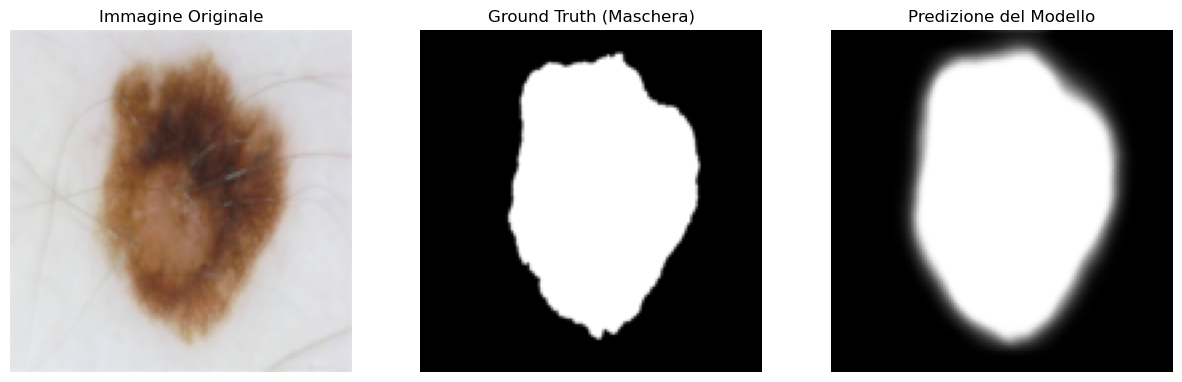

In [11]:
image, true_mask = next(iter(test_loader))  # Prendiamo la prima immagine dal DataLoader

print(f"Forma dell'immagine: {image.shape}") #8 (batch size) x 3 (RGB) x 128 x 128

# Disabilitiamo il calcolo del gradiente (non serve durante l'inferenza)
with torch.no_grad():
    prediction = model(image)  


image_np = image[0].permute(1, 2, 0).numpy()  # Rimuove il batch (B, C, H, W) -> (C, H, W) e poi permuta (H, W, C)
true_mask_np = true_mask[0].squeeze(0).numpy()  # Rimuove la dimensione del canale (1, H, W) -> (H, W)
predicted_mask_np = prediction[0].squeeze(0).numpy()  # Rimuove la dimensione del canale (1, H, W) -> (H, W)


plt.figure(figsize=(15, 5))

# Immagine originale
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title('Immagine Originale')
plt.axis('off')

# Maschera di verità a terra (ground truth)
plt.subplot(1, 3, 2)
plt.imshow(true_mask_np, cmap='gray')
plt.title('Ground Truth (Maschera)')
plt.axis('off')

# Predizione del modello
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_np, cmap='gray')
plt.title('Predizione del Modello')
plt.axis('off')

plt.show()

La maschera non è binarizzata!

In [12]:
# Controlliamo il range dei pixel in image_np
print(f"Range dei valori nei pixel: Min = {image_np.min()}, Max = {image_np.max()}")

Range dei valori nei pixel: Min = 0.10980392247438431, Max = 0.9333333373069763


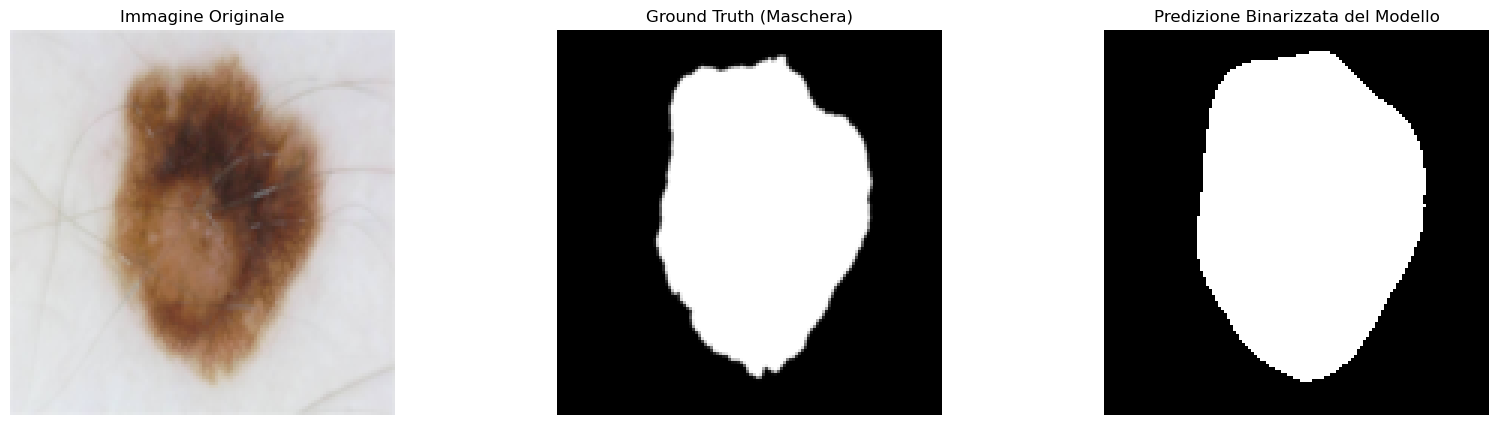

In [14]:
# Applichiamo una soglia per binarizzare la maschera predetta
threshold = 0.5
binary_predicted_mask_np = (predicted_mask_np > threshold).astype(float)  # Soglia: 0.5 -> 1 se sopra, 0 se sotto

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title('Immagine Originale')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(true_mask_np, cmap='gray')
plt.title('Ground Truth (Maschera)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(binary_predicted_mask_np, cmap='gray')
plt.title('Predizione Binarizzata del Modello')
plt.axis('off')

plt.show()

Visualizziamo altri 3 esempi!

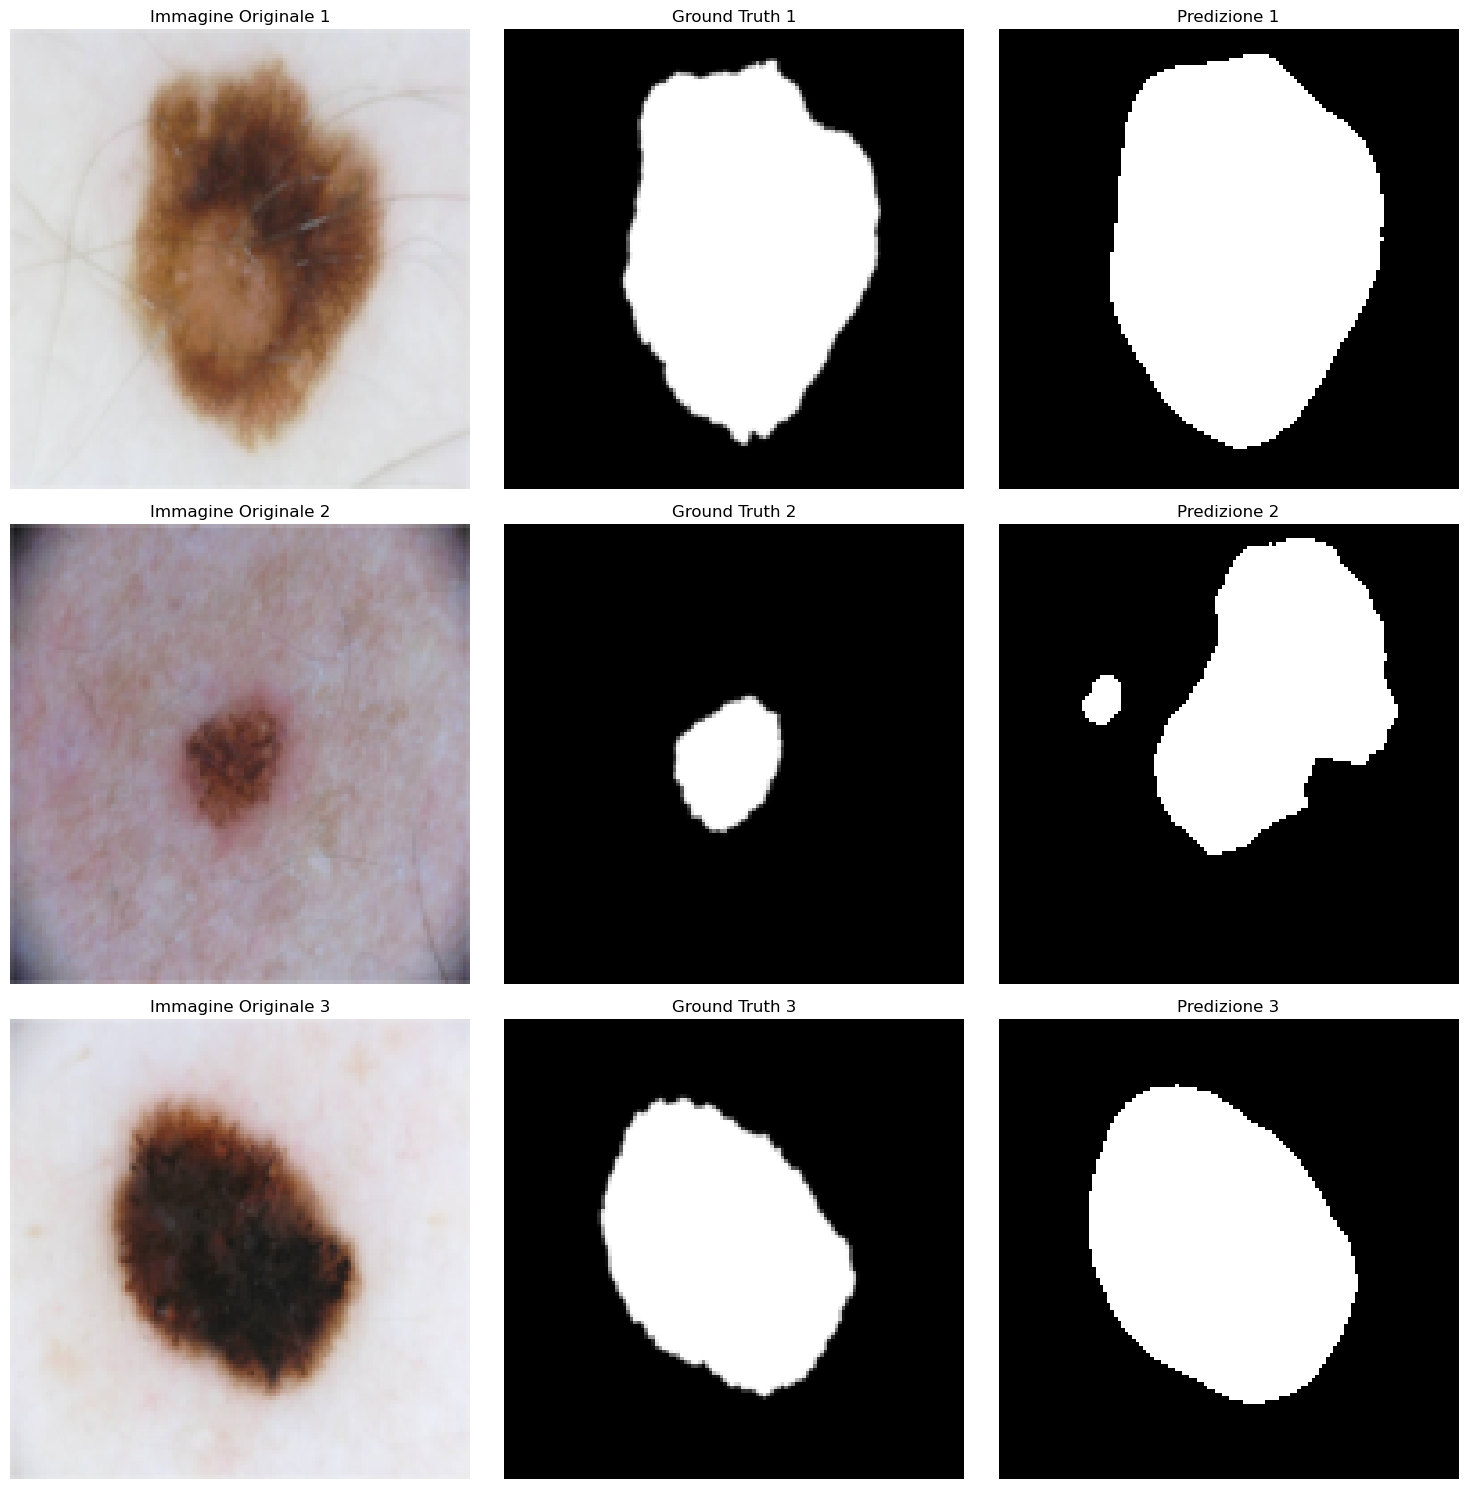

In [15]:
# Funzione per binarizzare le nostre maschere 
def binarize_mask(mask, threshold=0.5):
    return (mask > threshold).astype(float)

image, true_mask = next(iter(test_loader))  # Prendiamo la prima immagine dal DataLoader
with torch.no_grad():
    prediction = model(image)

num_examples = 3
plt.figure(figsize=(15, 5 * num_examples))

for i in range(num_examples):
    image_np = image[i].permute(1, 2, 0).numpy()  # Rimuove il batch e permuta (H, W, C)
    true_mask_np = true_mask[i].squeeze(0).numpy()  # Rimuove la dimensione del canale (1, H, W) -> (H, W)
    predicted_mask_np = prediction[i].squeeze(0).numpy()  # Rimuove la dimensione del canale (1, H, W) -> (H, W)
    
    # Binarizziamo la maschera predetta
    predicted_mask_np = binarize_mask(predicted_mask_np)

    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(image_np)
    plt.title(f'Immagine Originale {i+1}')
    plt.axis('off')
    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')
    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(predicted_mask_np, cmap='gray')
    plt.title(f'Predizione {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
